In [1]:
from comm_utils import load_server_data, load_client_data, process_rounds_time, filter_round_time, network_log_to_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from types import SimpleNamespace
from box import Box
import json

In [7]:
exp_path = "/home/tunguyen/energyfl/outputcifar10/10clients/comm/fedavg/labelskew/2024-04-26_01-39-25"

In [8]:
def read_server_clients_data(exp_path):
    host_ids = [int(name.split('_')[-1]) for name in os.listdir(exp_path) if 'client' in name]
    outputs = Box()
    for i in host_ids:
        #client_path = os.path.join(exp_path, f'client_host_{i}')
        client_processes, client_fittimes, client_energy, client_network, client_df = load_client_data(exp_path, i)
        outputs[f'client_{i}'] = Box(processes=client_processes, energy=client_energy, time=client_fittimes, network=client_network, log=client_df)
    server_path = os.path.join(exp_path, 'server')
    server_processes, server_energy, server_time, server_network, server_df = load_server_data(exp_path)
    outputs['server'] = Box(processes=server_processes, energy=server_energy, time=server_time, network=server_network, df=server_df)
    return outputs

In [9]:
files = read_server_clients_data(exp_path)

In [10]:
def plot_multples_clients(file_holder):
    server_time = file_holder.server.time
    clients = sorted([client for client in file_holder.keys() if 'client' in client])
    server_round_time = process_rounds_time(server_time, mode='round')
    server_filter = filter_round_time(server_round_time, file_holder.server.network)
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 5))
    rounds = server_filter['round'].unique()
    for client in clients:
        client_network = file_holder[client].network
        client_filtered = filter_round_time(server_round_time, client_network)
        sends, receives = [], []
        for r in rounds:
            send_sum = client_filtered[client_filtered['round'] == r].send.sum()/1024
            recv_sum = client_filtered[client_filtered['round'] == r].receive.sum()/1024
            sends.append(send_sum)
            receives.append(recv_sum)
        axs[0].plot(rounds, sends, label=f"{client}")#,marker='^', markevery=1, linewidth=2)
        axs[1].plot(rounds, receives, label=f"{client}")#,marker='^', markevery=1, linewidth=2)
    
    axs[0].set_title("Send")
    axs[1].set_title("Receive")
    axs[0].set_ylabel("MB")
    axs[1].set_ylabel("MB")
    axs[1].set_xlabel("Round")
    legend = fig.legend(clients, 
                        loc="upper center", 
                        bbox_to_anchor=(0.5, 1.0), 
                        ncol=len(clients),
                        fontsize=12,)
    
    fig_server, axs_server = plt.subplots(2, 1, figsize=(20, 10))
    server_sends, server_receives = [], []
    for r in rounds:
        send_sum = server_filter[server_filter['round'] == r].send.sum()/1024
        recv_sum = server_filter[server_filter['round'] == r].receive.sum()/1024
        server_sends.append(send_sum)
        server_receives.append(recv_sum)
    axs_server[0].plot(rounds, server_sends, label="Server")#,marker='^', markevery=1, linewidth=2)
    axs_server[1].plot(rounds, server_receives, label="Server")#,marker='^', markevery=1, linewidth=2)
    axs_server[0].set_title("Send")
    axs_server[1].set_title("Receive")
    axs_server[0].set_ylabel("MB")
    axs_server[1].set_ylabel("MB")
    axs_server[0].set_xlabel("Round")
    plt.legend()

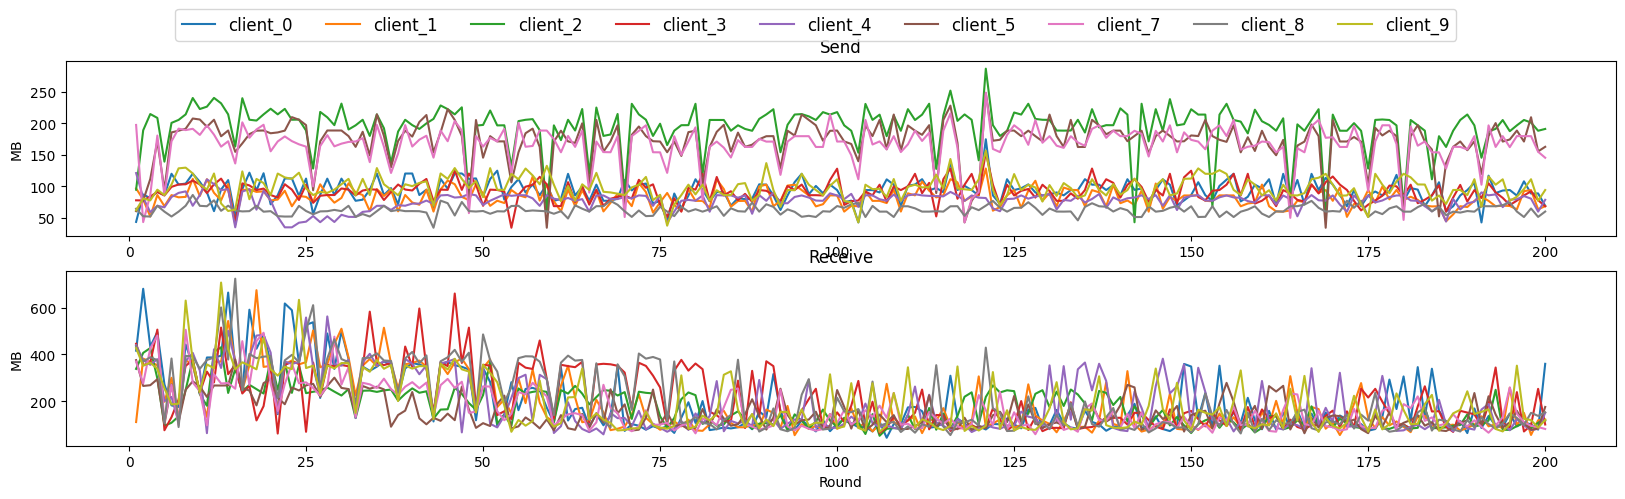

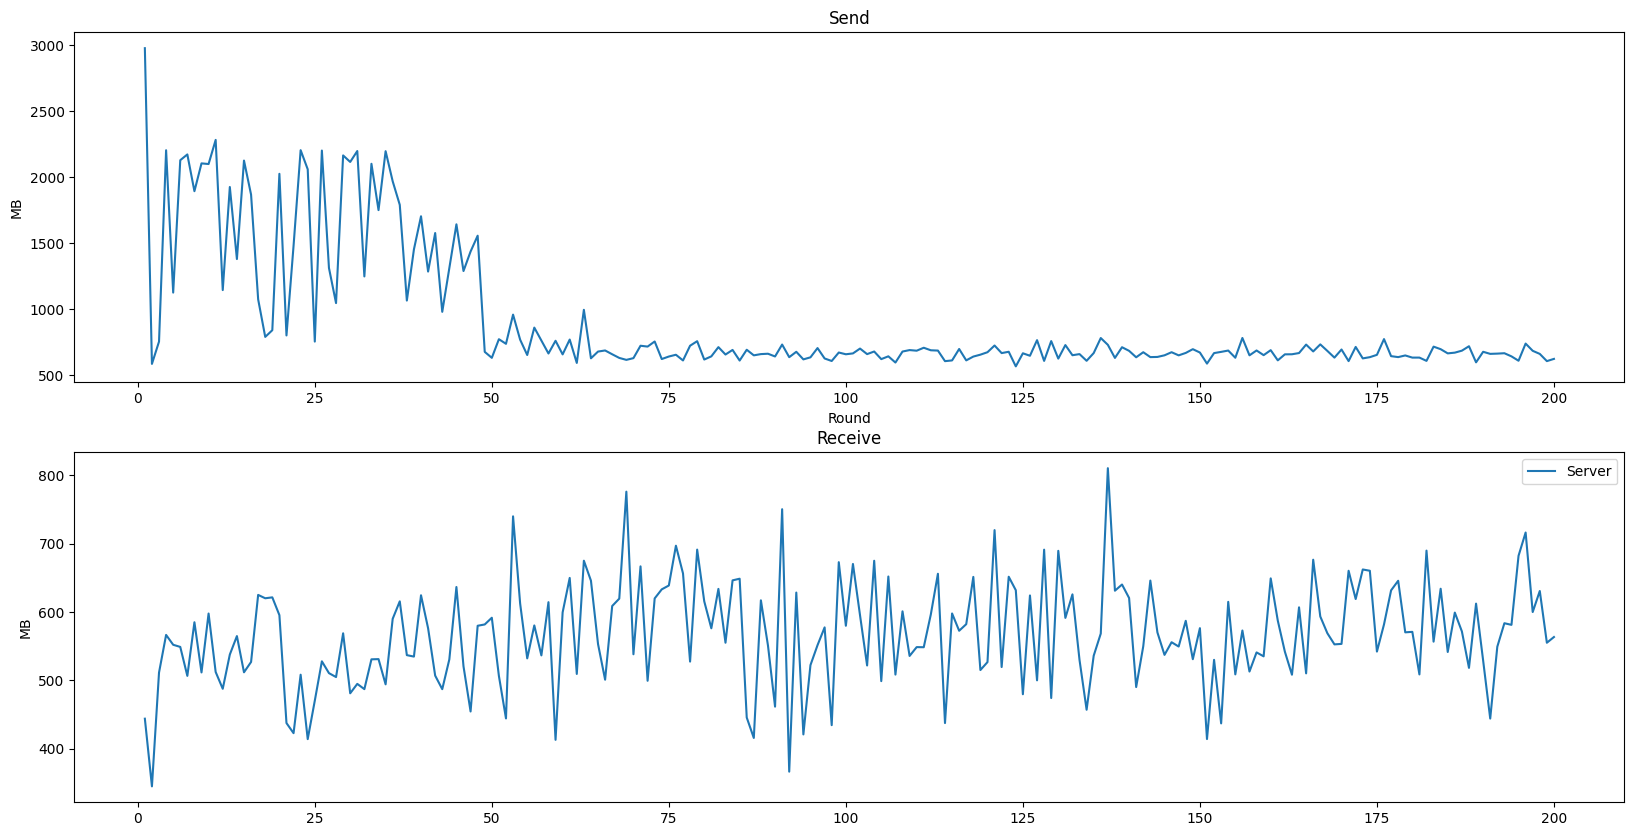

In [11]:
plot_multples_clients(files)